In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
%store -r data
%store -r target

In [3]:
data = standardize(data)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(data,target)

X_train shape: (8091, 51)
X_test shape: (999, 51)
X_val shape: (900, 51)
y_train shape: (8091,)
y_test shape: (999,)
y_val shape: (900,)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [4]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_dev, y_dev)
predsDevknn = model_knn.predict(X_dev)
predsTestknn = model_knn.predict(X_test)

In [5]:
testknn_score =  accuracy_score(y_test, predsTestknn)
devknn_score = accuracy_score(y_dev, predsDevknn)

In [6]:
print("Classification Score for K Neighbors Classifier on Dev dataset:\n")
print("Dev Score : ", devknn_score)
print(classification_report(y_dev, predsDevknn))
print("--------------------------------------------------------")
print("Classification Score for K Neighbors Classifier on Test dataset:\n")
print("Test Score :", testknn_score)
print(classification_report(y_test, predsTestknn))

Classification Score for K Neighbors Classifier on Dev dataset:

Dev Score :  0.9500611722833945
              precision    recall  f1-score   support

       blues       0.95      0.98      0.96       904
   classical       0.93      0.98      0.95       894
     country       0.92      0.92      0.92       886
       disco       0.91      0.96      0.94       890
      hiphop       0.97      0.95      0.96       901
        jazz       0.95      0.94      0.94       886
       metal       0.98      0.98      0.98       923
         pop       0.98      0.94      0.96       896
      reggae       0.95      0.97      0.96       904
        rock       0.96      0.89      0.92       907

    accuracy                           0.95      8991
   macro avg       0.95      0.95      0.95      8991
weighted avg       0.95      0.95      0.95      8991

--------------------------------------------------------
Classification Score for K Neighbors Classifier on Test dataset:

Test Score : 0.904904

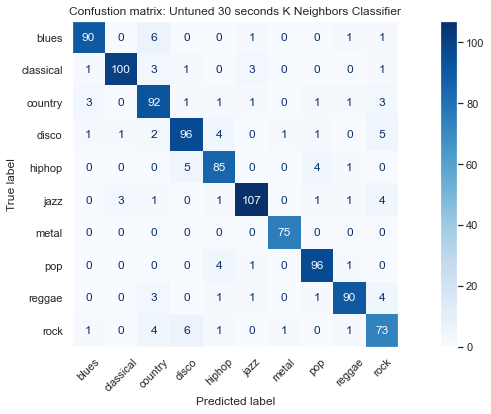

Accuracy : 0.90
Macro F-1 Score : 0.91


In [7]:
# Evaluate Model on Test set
class_labels = list(model_knn.classes_)
macro_f1, accuracy = evaluate_model(predsTestknn, y_test, class_labels, 'Confustion matrix: Untuned 30 seconds K Neighbors Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [8]:
parameters = {'n_neighbors':np.arange(2,10,1, dtype=int),
            'algorithm':[ 'ball_tree', 'kd_tree', 'brute']}
print(parameters)

{'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]), 'algorithm': ['ball_tree', 'kd_tree', 'brute']}


In [9]:
tune_knn = GridSearchCV(estimator = model_knn, param_grid = parameters, cv = 5)
tune_knn.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9])})

In [10]:
print("Best Score :", tune_knn.best_score_)
print("Best Parameters :",tune_knn.best_params_)

Best Score : 0.9036831115543735
Best Parameters : {'algorithm': 'ball_tree', 'n_neighbors': 3}


In [11]:
predsDevknn_tuned = tune_knn.predict(X_dev)
predsTestknn_tuned = tune_knn.predict(X_test)

print("Score on Dev data for KNN using GridSearchCV:", accuracy_score(y_dev, predsDevknn_tuned))
print("Score on Test data for KNN using GridSearchCV:",accuracy_score(y_test, predsTestknn_tuned))

Score on Dev data for KNN using GridSearchCV: 0.9674118563007452
Score on Test data for KNN using GridSearchCV: 0.923923923923924


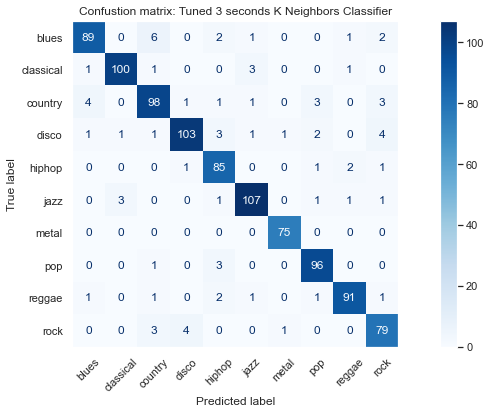

Accuracy : 0.92
Macro F-1 Score : 0.93


In [12]:
# Evaluate Model on Test set
class_labels = list(model_knn.classes_)
macro_f1, accuracy = evaluate_model(predsTestknn_tuned, y_test, class_labels, 'Confustion matrix: Tuned 3 seconds K Neighbors Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [13]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.11454404 0.08920634 0.04504717 0.02937379 0.02274578 0.0199205
 0.01584086 0.01368273 0.01132293 0.01090893 0.0089262  0.008148
 0.00722979 0.006841   0.00622568 0.00604714 0.00535507 0.00529878
 0.00508263 0.00483043 0.00471998 0.00416858 0.00364237 0.00346598
 0.00329018 0.00306155 0.00284064 0.00281153 0.00272198 0.00268147]
Sum of Explained Variance: 0.9367880325720113


In [14]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.262197,-0.041290,-0.004825,0.077376,-0.092647,-0.202191,0.134134,-0.029629,0.065911,0.012893,...,-0.035694,0.008521,-0.058729,-0.058040,-0.024358,0.002254,0.002259,-0.009337,-0.039735,blues
1,0.911816,0.656705,0.093061,0.041842,0.162399,-0.345911,-0.111060,0.005590,0.107239,0.058303,...,0.020828,-0.115690,0.038284,0.046206,0.027944,-0.077340,0.063196,-0.127674,0.031574,pop
2,-0.346865,0.190015,-0.015068,-0.042262,0.002093,-0.081459,-0.064502,-0.077144,-0.020687,-0.082224,...,-0.023584,0.041773,0.012639,0.001487,0.054557,-0.025331,-0.026409,-0.009324,-0.033106,rock
3,0.165602,-0.054123,-0.230414,-0.096289,0.254820,0.184295,-0.224993,0.078011,-0.083900,-0.040356,...,0.058693,0.025465,0.052070,0.004858,-0.012445,0.016864,-0.130463,-0.002198,-0.059973,jazz
4,-0.213596,0.153496,0.162250,0.171556,0.164251,-0.038909,0.033234,0.036491,0.089944,0.132908,...,0.094559,0.053202,0.076214,-0.040750,-0.001110,-0.056791,-0.024677,-0.008729,-0.037760,hiphop


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [15]:
model_pca = KNeighborsClassifier()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainknn = model_pca.predict(pca_data)
pcaTestknn = model_pca.predict(pca_data_test)

In [16]:
pcatestknn_score =  accuracy_score(y_test, pcaTestknn)
pcaknn_score = accuracy_score(y_dev, pcaTrainknn)

In [17]:
print("Classification Score for K Neighbors Classifier on Train dataset:\n")
print("Train Score : ", pcaknn_score)
print("--------------------------------------------------------")
print("Classification Score for K Neighbors Classifier on Test dataset:\n")
print("Test Score :", pcatestknn_score)

Classification Score for K Neighbors Classifier on Train dataset:

Train Score :  0.9457235012790568
--------------------------------------------------------
Classification Score for K Neighbors Classifier on Test dataset:

Test Score : 0.9019019019019019


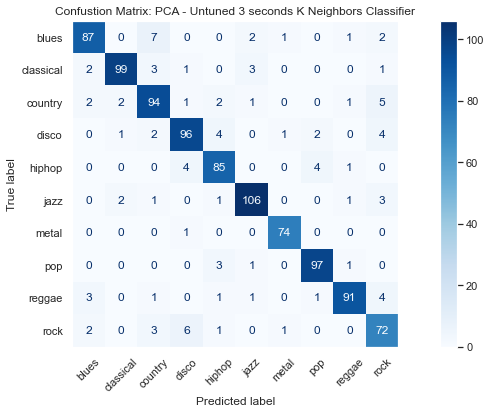

Accuracy : 0.90
Macro F-1 Score : 0.90


In [18]:
# Evaluate Model
class_labels = list(model_knn.classes_)
macro_f1, accuracy = evaluate_model(pcaTestknn, y_test, class_labels, 'Confustion Matrix: PCA - Untuned 3 seconds K Neighbors Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [19]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.262197,-0.041290,-0.004825,0.077376,-0.092647,-0.202191,0.134134,-0.029629,0.065911,0.012893,...,-0.010461,-0.035694,0.008521,-0.058729,-0.058040,-0.024358,0.002254,0.002259,-0.009337,-0.039735
1,0.911816,0.656705,0.093061,0.041842,0.162399,-0.345911,-0.111060,0.005590,0.107239,0.058303,...,0.005562,0.020828,-0.115690,0.038284,0.046206,0.027944,-0.077340,0.063196,-0.127674,0.031574
2,-0.346865,0.190015,-0.015068,-0.042262,0.002093,-0.081459,-0.064502,-0.077144,-0.020687,-0.082224,...,-0.049052,-0.023584,0.041773,0.012639,0.001487,0.054557,-0.025331,-0.026409,-0.009324,-0.033106
3,0.165602,-0.054123,-0.230414,-0.096289,0.254820,0.184295,-0.224993,0.078011,-0.083900,-0.040356,...,-0.024682,0.058693,0.025465,0.052070,0.004858,-0.012445,0.016864,-0.130463,-0.002198,-0.059973
4,-0.213596,0.153496,0.162250,0.171556,0.164251,-0.038909,0.033234,0.036491,0.089944,0.132908,...,-0.050481,0.094559,0.053202,0.076214,-0.040750,-0.001110,-0.056791,-0.024677,-0.008729,-0.037760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8986,0.223969,0.199646,-0.304657,0.107035,0.128513,-0.077394,0.112853,-0.020114,-0.039319,0.079172,...,-0.060983,0.002907,0.039690,0.018512,0.060249,-0.030236,0.043471,0.024727,-0.053827,0.038602
8987,-0.606602,0.172697,-0.153625,0.181308,-0.121463,0.157416,0.025886,0.059130,-0.051091,-0.138453,...,-0.001286,-0.033903,-0.049504,0.007715,-0.007403,-0.022222,-0.019956,-0.049995,0.031313,0.033528
8988,-0.049191,0.533015,0.390142,-0.164059,0.121949,0.004291,0.132506,-0.029939,0.190393,0.052235,...,0.008791,0.096152,0.103564,-0.005147,0.012375,0.098187,0.001234,-0.103296,0.087009,0.033044
8989,0.060511,-0.364952,-0.044975,-0.081345,-0.295757,-0.073174,-0.190964,-0.031097,-0.108378,0.086462,...,-0.088791,-0.007800,0.001535,-0.061376,-0.037828,0.154156,0.008259,-0.025511,0.016314,-0.039073


In [20]:
model_pca_tuned = tune_knn
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainknn_tuned = model_pca_tuned.predict(pca_data)
pcaTestknn_tuned = model_pca_tuned.predict(pca_data_test)

In [21]:
pcatestknn_score =  accuracy_score(y_test, pcaTestknn_tuned)
pcaknn_score = accuracy_score(y_dev, pcaTrainknn_tuned)

In [22]:
print("Classification Score for K Neighbors Classifier on Train dataset:\n")
print("Train Score : ", pcaknn_score)
print("--------------------------------------------------------")
print("Classification Score for K Neighbors Classifier on Test dataset:\n")
print("Test Score :", pcatestknn_score)

Classification Score for K Neighbors Classifier on Train dataset:

Train Score :  0.9606272939606273
--------------------------------------------------------
Classification Score for K Neighbors Classifier on Test dataset:

Test Score : 0.9159159159159159


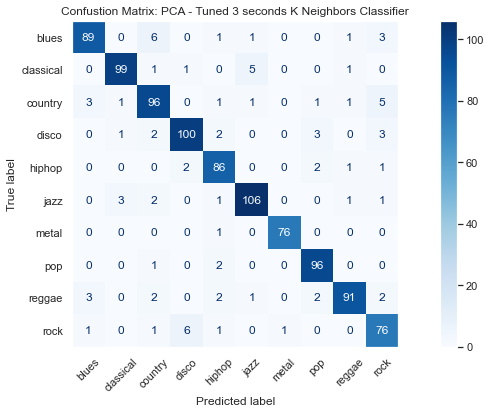

Accuracy : 0.92
Macro F-1 Score : 0.92


In [23]:
# Evaluate Model
class_labels = list(model_knn.classes_)
macro_f1, accuracy = evaluate_model(pcaTestknn_tuned, y_test, class_labels, 'Confustion Matrix: PCA - Tuned 3 seconds K Neighbors Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)